In [1]:
from datetime import datetime, timedelta
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()
%matplotlib inline
%config IPCompleter.greedy = True
import numpy as np
import matplotlib.pyplot as plt
import cbpro
import urllib.request
import ssl
import json
import time
import os
from pathlib import Path
import seaborn as sns

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
np.set_printoptions(suppress=True)

public_client = cbpro.PublicClient()


Loading BokehJS ...

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
class MinerMeta(type):
    def compile_historic(self, num_days=100, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv is True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            finish = datetime.now()
            start = finish - timedelta(num_days)
            delta = timedelta(hours=300)
            df = pd.DataFrame()

            while finish > start:
                historic = public_client.get_product_historic_rates(
                    f"{self.coin}-USD",
                    granularity=3600,
                    start=start,
                    end=start + delta,
                )
                start += delta
                df = df.append(historic, ignore_index=True, verify_integrity=True)
            df.columns = ["time", "low", "high", "open", "close", "volume"]
            date_time = pd.to_datetime(df["time"], unit="s")
            # df.set_index("time", inplace=True)
            df.sort_values(by="time", ascending=False, inplace=True)

            timestamp_s = date_time.map(pd.Timestamp.timestamp)
            day = 24 * 60 * 60
            year = (365.2425) * day
            df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
            df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
            df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
            df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
            df.reset_index(drop=True, inplace=True)
            df["time"] = pd.to_datetime(df["time"], unit="s")
            df.set_index("time", inplace=True, verify_integrity=False)
            df.sort_index(ascending=False)
            if write_csv is True:
                df.to_csv(file, index=True)

            return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()
        ylim = int(df[col].max())
        plt.figure(figsize=(15, 10))


        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        hours_per_week = 24 * 7
        years_per_dataset = n_samples_h / (hours_per_year)
        hours_per_dataset = n_samples_h / (hours_per_week)

        f_per_year = f_per_dataset / years_per_dataset
        f_per_week = f_per_dataset / hours_per_dataset
        plt.step(f_per_week, np.abs(fft))
        plt.xscale("log")
        # plt.ylim(1000, ylim)
        # plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 7], labels=["1/Week", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


In [3]:
# Lunar Crush API Key
#https://lunarcrush.com/developers/docs#assets
api_key = r"ru1zaf0ssaa29394mb4ahp"

# coins = ["BTC", "ETH", "LTC"]
coins = "ETH"

# coins = ",".join(coins)

map = [
    {"name": ""},
    {"symbol": ""},
    {"price": " Price: "},
    {"percent_change_24h": " - 24 Hour Percent Change: "},
    {"average_sentiment": " Average Sentiment: "},
]


def final_render(asset_coin, value, key, asset):
    if key == "symbol":
        asset_coin += " (" + asset[key] + ")"
    elif key == "percent_change_24h":
        asset_coin += value + str(asset[key]) + "%"
    else:
        asset_coin += value + str(asset[key])
    return asset_coin


def lc_data():

    assets_url = (
        "https://api.lunarcrush.com/v2?data=assets&key=" + api_key + "&symbol=" + coins
    )
    assets = json.loads(urllib.request.urlopen(assets_url).read())
    # config = pd.DataFrame.from_dict(assets["config"], orient="index")
    # usage = pd.DataFrame.from_dict(assets["usage"], orient="index")
    data = pd.DataFrame.from_dict(assets["data"])
    return data

    # feeds_url = (
    #     "https://api.lunarcrush.com/v2?data=feeds&key=" + api_key + "&symbol=" + coins
    # )
    # assets = json.loads(urllib.request.urlopen(feeds_url).read())
    # print(assets)
    # config = pd.DataFrame.from_dict(assets["config"])

    # time_series = pd.DataFrame.from_dict(assets["timeSeries"])
    # for asset in assets["data"]:
    #     asset_coin = ""
    #     for field in map:
    #         print(field)
    #     key = list(field.keys())[0]
    #     value = list(field.values())[0]
    #     asset_coin = final_render(asset_coin, value, key, asset)


In [4]:
from pathlib import Path
file = Path.cwd() / 'lunardata.csv'
data = lc_data()
data.head()

,id,name,symbol,price,price_btc,market_cap,percent_change_24h,percent_change_7d,percent_change_30d,volume_24h,...,medium,youtube,social_contributors,social_volume,social_volume_global,social_dominance,market_cap_global,market_dominance,tags,close
0,2,Ethereum,ETH,3044.767017,0.070118,358157125539,3.35,-15.8,-8.45,9.157254e+10,...,1,2,5478,5981,79087,7.562558,2235101687702,15.935141,,3044.767017


In [5]:
df = eth.compile_historic(write_csv=True)
num_features = df.shape[1]

train_df, val_df, test_df = eth.ttsplit_norm(df)


In [6]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        label_columns=None,
        df=df,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
    ):
        # Store the raw data.
        self.df = df
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_ds(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    def plot(self, model=None, plot_col="close", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(15, 10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                # edgecolors="k",
                # label="Labels",
                # c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    # edgecolors="k",
                    # label="Predictions",
                    # c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    @property
    def train(self):
        return self.make_ds(self.train_df)

    @property
    def val(self):
        return self.make_ds(self.val_df)

    @property
    def test(self):
        return self.make_ds(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


In [7]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history


In [8]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [9]:
OUT_STEPS = 24 * 7
multi_val_performance = {}
multi_performance = {}
multi_window = WindowGenerator(
    input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS
)
multi_window

Total window size: 336
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 

In [10]:
df.head()

,low,high,open,close,volume,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,
2021-09-22 09:00:00,2908.28,2946.56,2928.09,2945.88,3480.928036,0.707107,-7.071068e-01,-0.988238,-0.152922
2021-09-22 08:00:00,2921.03,2958.28,2943.46,2927.83,3862.916391,0.866025,-5.000000e-01,-0.988128,-0.153630
2021-09-22 07:00:00,2914.01,2961.80,2931.09,2943.90,7789.365781,0.965926,-2.588190e-01,-0.988018,-0.154338
2021-09-22 06:00:00,2854.42,2935.40,2874.08,2931.02,7475.436776,1.000000,8.810587e-12,-0.987907,-0.155046
2021-09-22 05:00:00,2843.81,2894.25,2843.88,2874.13,7773.448416,0.965926,2.588190e-01,-0.987796,-0.155754


Epoch 1/20
43/43 [==============================] - 14s 46ms/step - loss: 0.3262 - mean_absolute_error: 0.3482 - val_loss: 0.1946 - val_mean_absolute_error: 0.2739
Epoch 2/20
43/43 [==============================] - 1s 31ms/step - loss: 0.2164 - mean_absolute_error: 0.2361 - val_loss: 0.2035 - val_mean_absolute_error: 0.2960
Epoch 3/20
43/43 [==============================] - 1s 30ms/step - loss: 0.1740 - mean_absolute_error: 0.1854 - val_loss: 0.2035 - val_mean_absolute_error: 0.2967
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.2127 - mean_absolute_error: 0.3112
Wall time: 19.1 s


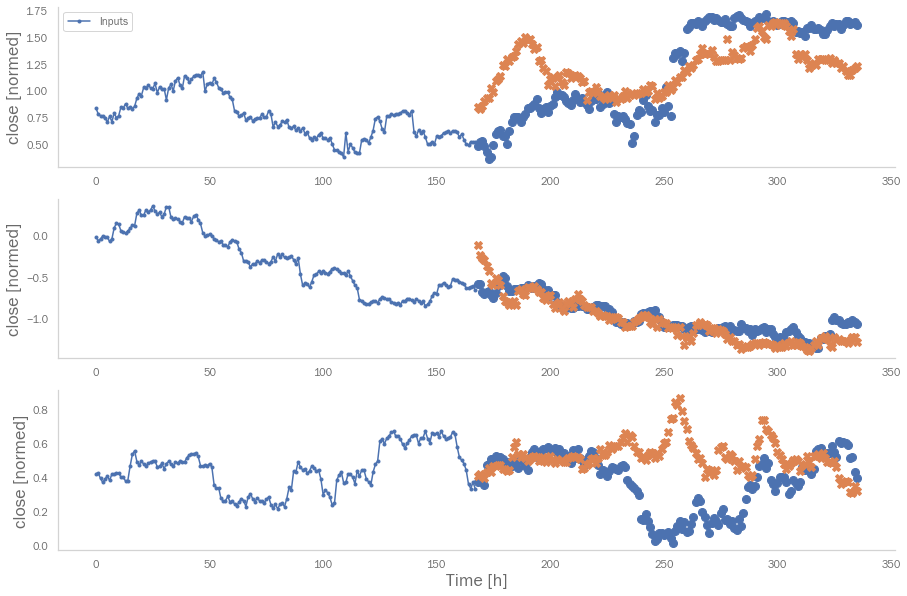

In [11]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, multi_window)

multi_val_performance['Residual LSTM'] = residual_lstm.evaluate(multi_window.val)
multi_performance['Residual LSTM'] = residual_lstm.evaluate(multi_window.test, verbose=0)
multi_window.plot(residual_lstm)

Epoch 1/20
43/43 [==============================] - 12s 71ms/step - loss: 0.2119 - mean_absolute_error: 0.2914 - val_loss: 0.4203 - val_mean_absolute_error: 0.5122
Epoch 2/20
43/43 [==============================] - 2s 56ms/step - loss: 0.1237 - mean_absolute_error: 0.1824 - val_loss: 0.4632 - val_mean_absolute_error: 0.5344
Epoch 3/20
43/43 [==============================] - 2s 53ms/step - loss: 0.1107 - mean_absolute_error: 0.1684 - val_loss: 0.4423 - val_mean_absolute_error: 0.5250
Epoch 4/20
5/5 [==============================] - 0s 37ms/step - loss: 0.4789 - mean_absolute_error: 0.5593


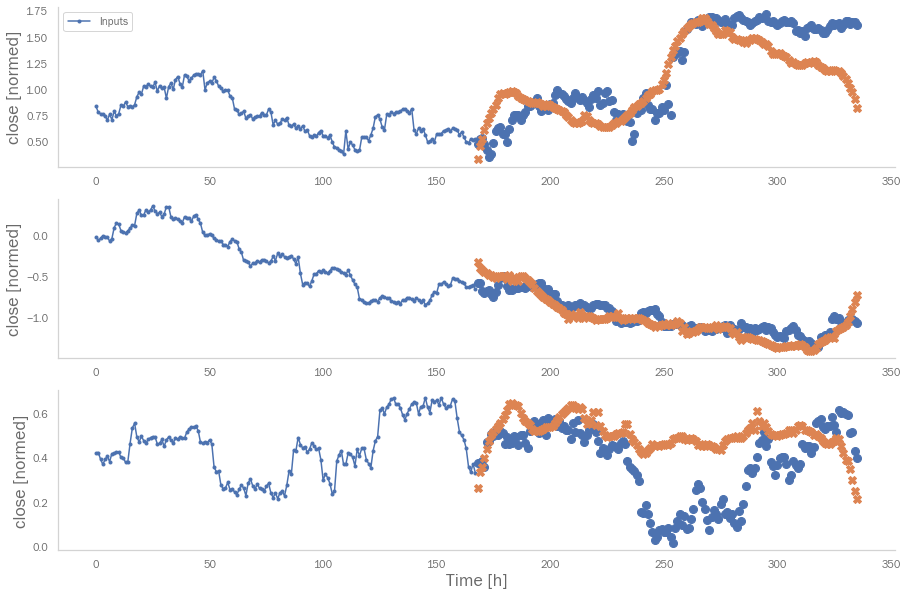

In [12]:
CONV_WIDTH = 3

dev_model = tf.keras.models.Sequential(
    [
        # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(CONV_WIDTH),
            strides=1,
            padding="causal",
            activation="relu",
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        # tf.keras.layers.Bidirectional(
        #     tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dense(128),
        # tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(num_features),
    ]
)

history = compile_and_fit(dev_model, multi_window)

multi_val_performance["DEV"] = dev_model.evaluate(multi_window.val)
multi_performance["DEV"] = dev_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(dev_model)


In [13]:
for name, value in multi_performance.items():
    print(f"{name:8s}: {value[1]:0.4f}")


IndexError: list index out of range

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test)
multi_window.plot(multi_dense_model)


In [ ]:
df = multi_window.df
df.plot_bokeh()